# Sprint 2: Unsupervised learning

Tijdens deze tweede sprint wordt gefocust op het clusteren van de data. Aan de hand van de verschillende klachtbeschrijvingen trachten we de verschillende categorieën voor de producten en issues te voorspellen zonder de categorieën opvoorhand te specifiëren (unsupervised learning). Op die manier trachten we de klachten op een betere manier te groeperen in vergelijking met de reeds gedefinieërde categorieën in de dataset.

We zullen in deze sprint met meerdere technieken gaan experimenteren en telkens de onderlinge resultaten gaan vergelijken.
1. Topic modeling: LDA (Latent Dirichlet Allocation)
2. K-means clustering
3. DBScan clustering

Voor elke techniek gaan we de data pre-processing en feature extraction apart behandelen aangezien de resultaten van de verschillende technieken hiervan sterk afhankelijk zijn.

## Inlezen dataset

De data exploratie wordt hier beperkt tot enkel het inlezen van de vereiste data. Dit werd reeds tijdens sprint 1 uitvoerig behandeld.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rows_to_read = None # Gewenst aantal rijen inlezen (None = allemaal)

complaints_df = pd.read_csv('../data/complaints.csv', delimiter=',', nrows=rows_to_read)
complaints_df = complaints_df[['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative']].copy()
complaints_df.columns = ['Product', 'Sub_Product', 'Issue', 'Sub_Issue', 'Narrative'] 
complaints_df.head()

,Product,Sub_Product,Issue,Sub_Issue,Narrative
0,"Credit reporting, credit repair services, or o...",Credit reporting,Credit monitoring or identity theft protection...,Problem canceling credit monitoring or identif...,I have complained many times that the credit r...
1,Debt collection,I do not know,False statements or representation,Attempted to collect wrong amount,please review the current fraud account and al...
2,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,Called multiple times over the years for a deb...
3,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,I sent in a letter to the company to have them...
4,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Received unsolicited financial product or insu...,On XX/XX/19 I applied for a Debt Relief Produc...


In [30]:
product_count = len(complaints_df.Product.unique())
print('Aantal product categorieën:', product_count)

Aantal product categorieën: 18


## 1. Topic modeling: Latent Dirichlet Allocation

Topic modeling wordt gebruikt om tekst uit een document te classificeren onder een specifiek onderwerp. Per document wordt een 'topic' bepaald, en per 'topic' worden de woorden bepaald die tot dit onderwerp behoren. LDA neemt aan dat elk document bestaat uit woorden die op een of andere manier gerelateerd zijn aan elkaar, en probeert deze onderliggende verbanden te zoeken.

### Data pre-processing

Tijdens de vorige sprint hebben we gezien dat de dataset zeer ongebalanceerd is. Tijdens uitvoering van het experiment zowel met als zonder balanceren uitvoeren. Hierbij wordt data weggelaten uit de categorieën die het meest voorkomen (undersampling).

Klachten worden gefilterd aan de hand van de volgende voorwaarden:
- **tokenization**: tekst wordt opgesplitst in een sequentie van woorden zonder punctuatie en alles in lower case
- woorden met **minder dan 3 karakters** worden weggelaten
- **stopwoorden** worden verwijderd
- **werkwoorden in derde persoon** worden veranderd naar de eerste persoon
- **werkwoorden in verleden tijd** worden veranderd naar het heden
- woorden worden gereduceerd tot hun **stamvorm**
- alles wat niet gelijk is aan een lowercase of whitespace eruit filteren, alle getallen eruit filteren, returns en newlines eruithalen, kaartnummers eruit filteren

In [2]:
# pip install nltk
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import re
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer

def processing(string):
    # omzetten naar lowercase 
    string = string.lower()
    # alles wat niet gelijk is aan een lowercase of whitespace eruit filteren
    string = re.sub(r'[^\w\s]', '', string)
    # alle getallen eruit filteren
    string = re.sub(r'[0-9]|,', '', string)
    # returns en newlines eruithalen
    string = string.replace('\r', ' ')
    string = string.replace('\n', ' ')
    # kaartnummers staan in de tekst als volgt XXX XXX ..., deze eruit filteren
    string = re.sub(r'[X|x]{2,}', ' ', string)
    # de string splitten om de stopwoorden er afzonderlijk uit te halen
    tokens = string.split(' ')
    tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS and len(w) > 3]
    ## werkwoord vervoegingen veranderen en woorden reduceren naar stamvorm
    result = [SnowballStemmer('english').stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in tokens]
    return ' ' . join(result)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
complaints_df['Narrative_Processed'] = complaints_df['Narrative'].apply(processing)

In [5]:
complaints_df[['Narrative', 'Narrative_Processed']]

,Narrative,Narrative_Processed
0,I have complained many times that the credit r...,complain time credit report experian inaccur j...
1,please review the current fraud account and al...,review current fraud account fraudul inquir
2,Called multiple times over the years for a deb...,call multipl time year debt occur previous mar...
3,I sent in a letter to the company to have them...,send letter compani valid debt special attach ...
4,On XX/XX/19 I applied for a Debt Relief Produc...,appli debt relief product account execut expla...
...,...,...
485696,This account was a payday loan from the XXXX X...,account payday loan year complet request loan ...
485697,We had a mortgage with XXXX that was discharge...,mortgag discharg chapter bankruptci year compa...
485698,I have 2003 XXXX financed through United Auto ...,financ unit auto credit payment motor lock sei...
485699,I was on automatic payment for my car loan. In...,automat payment loan fine print suppos final p...


### Bag of words (BoW)

Om de LDA analyse te starten, moeten we de tekstuele data omvormen naar een simpele vector representatie die voor elke klacht het aantal keer een woord voorkomt gaat gaan tellen (Bag of Words).

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
bag_of_words = count_vectorizer.fit_transform(complaints_df['Narrative_Processed'])

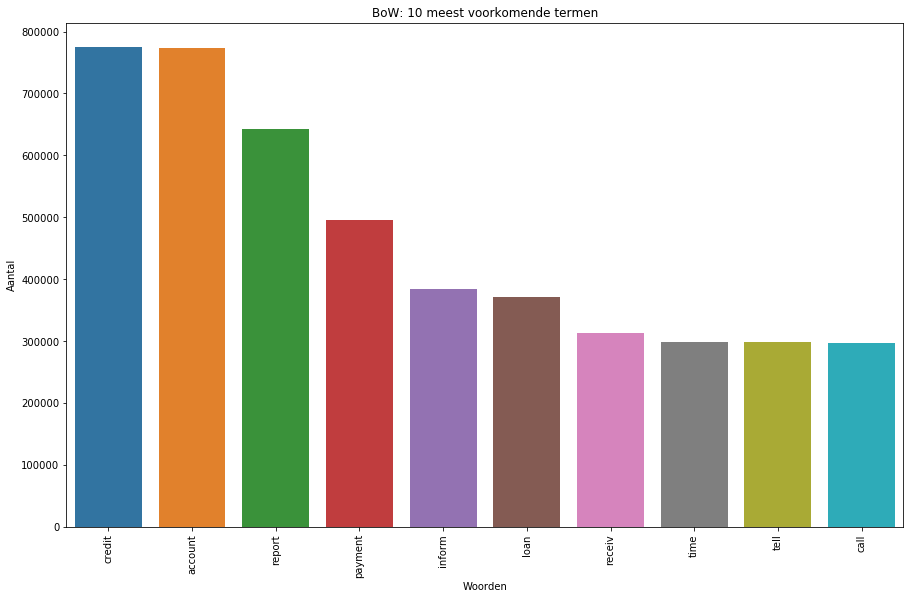

In [7]:
words = count_vectorizer.get_feature_names()
total_counts = np.zeros(len(words))
for t in bag_of_words:
    total_counts += t.toarray()[0]

count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words)) 

plt.figure(2, figsize=(15, 15/1.6180))
plt.subplot(title='BoW: 10 meest voorkomende termen')
sns.barplot(x_pos, counts)
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('Woorden')
plt.ylabel('Aantal')
plt.show()

### LDA model training

In [23]:
import os
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=product_count, n_jobs=os.cpu_count())
lda.fit(bag_of_words)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=18, n_jobs=32,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [24]:
number_words = 15

print("Topics gevonden met LDA:")
words = count_vectorizer.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("\nTopic #%d:" % topic_idx)
    print(" ".join([words[i] for i in topic.argsort()[:-number_words - 1:-1]]))

Topics gevonden met LDA:

Topic #0:
credit report remov inquiri inform account disput file equifax bureaus transunion experian delet bankruptci item

Topic #1:
claim citi report alleg document complianc complet collect requir complaint compliant practic fact applic debt

Topic #2:
bank account check chase money transact america charg card well fargo deposit fund fee debit

Topic #3:
consum inform report account section agenc verifi block request provid fcra file credit violat requir

Topic #4:
mortgag loan home modif properti payment escrow time foreclosur servic document hous sale request month

Topic #5:
credit vehicl tell financ purchas say go leas compani time card want auto know just

Topic #6:
credit secur report inform address number social equifax freez servic card onlin tri account access

Topic #7:
charg card insur disput servic cancel receiv credit refund bill purchas pay call time tell

Topic #8:
debt collect credit account valid report agenc compani origin provid request c

## 2. K-means clustering

## 3. DBScan clustering